## Predicting Optimal Fertilizer

## TODO LIST
CROSSVALIDATION für RDM und REGRESSION 
HYPERPARAM EINBAUEN TESTEN ANZEIGEN SCHLUSSFOLGERN
NOTEBOOK AUFRÄUMEN SCHÖNER MACHEN
MEHR GRAFIKEN FÜR DIE ERGEBNISSE


In [17]:
!pip install -U kaggle -q
!pip install pandas matplotlib seaborn scikit-learn xgboost kaggle




[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import pandas as pd
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV


In [19]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import os, json

auth_data = json.load(open('kaggle.json'))
os.environ['KAGGLE_USERNAME'] = 'guppi360'
os.environ['KAGGLE_KEY'] = '7d6dd61df722878af328a4ddb9fe2e90'
os.makedirs('./data', exist_ok=True)

!kaggle competitions download -c playground-series-s5e6 -p ./data
# für Jypter !unzip -o ./data/playground-series-s5e6.zip -d ./data
zip_path = './data/playground-series-s5e6.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('./data')

playground-series-s5e6.zip: Skipping, found more recently modified local copy (use --force to force download)


In [20]:
# CSVs aus dem Verzeichniss laden
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
sample = pd.read_csv("./data/sample_submission.csv")

# Überblick
print("Train shape:", train.shape)
print("Test shape: ", test.shape)
print("Sample shape:", sample.shape)

display(train.head())


Train shape: (750000, 10)
Test shape:  (250000, 9)
Sample shape: (250000, 2)


,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


3. Exploratory Data Analysis (EDA)

In [21]:
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

Train Shape: (750000, 10)
Test Shape: (250000, 9)


,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous
0,750000,31,70,52,Sandy,Wheat,34,11,24
1,750001,27,62,45,Red,Sugarcane,30,14,15
2,750002,28,72,28,Clayey,Ground Nuts,14,15,4
3,750003,37,53,57,Black,Ground Nuts,18,17,36
4,750004,31,55,32,Red,Pulses,13,19,14


Train Columns:
 ['id', 'Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type', 'Nitrogen', 'Potassium', 'Phosphorous', 'Fertilizer Name']

Test Columns:
 ['id', 'Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type', 'Nitrogen', 'Potassium', 'Phosphorous']

Target Distribution:
Fertilizer Name
14-35-14    0.152581
10-26-26    0.151849
17-17-17    0.149937
28-28       0.148211
20-20       0.147852
DAP         0.126480
Urea        0.123089
Name: proportion, dtype: float64

Missing values in train:
 id                 0
Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64

Missing values in test:
 id             0
Temparature    0
Humidity       0
Moisture       0
Soil Type      0
Crop Type      0
Nitrogen       0
Potassium      0
Phosphorous    0
dtype: int64

Data Types:
 id                  int64
Temparature         int64

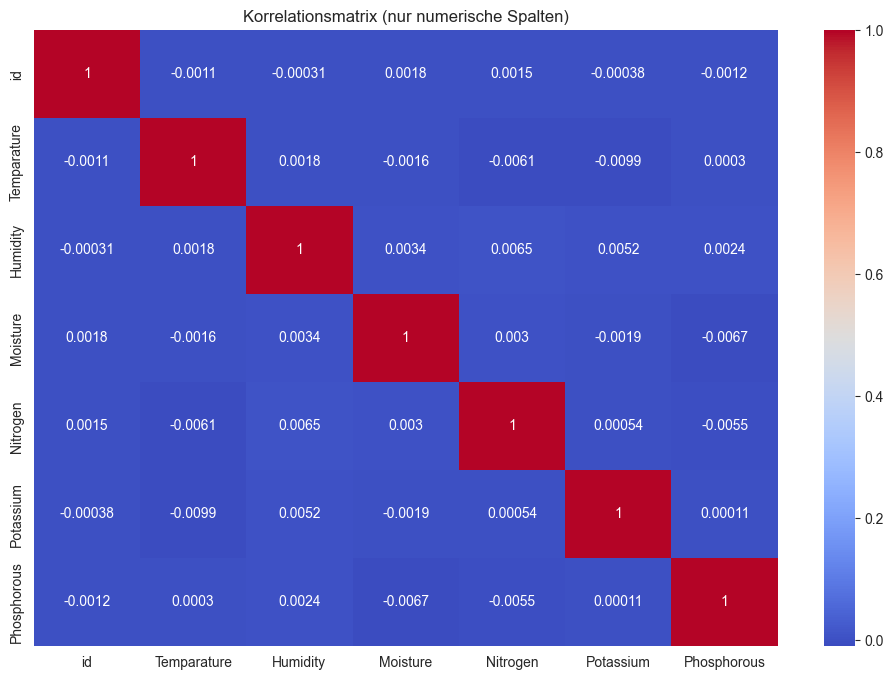

In [22]:
# Zeige die ersten Zeilen
display(train.head())
display(test.head())

# Notebook-Zelle 4: Übersicht über Spalten
print("Train Columns:\n", train.columns.tolist())
print("\nTest Columns:\n", test.columns.tolist())

# Notebook-Zelle 5: Zielverteilung
print("\nTarget Distribution:")
print(train['Fertilizer Name'].value_counts(normalize=True).head(10))  # die häufigsten

# Notebook-Zelle 6: Fehlende Werte?
print("\nMissing values in train:\n", train.isnull().sum())
print("\nMissing values in test:\n", test.isnull().sum())

# Notebook-Zelle 7: Datentypen
print("\nData Types:\n", train.dtypes)

# Korrelationen numerischer Features visualisieren
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns
if len(numeric_cols) > 1:
    plt.figure(figsize=(12,8))
    sns.heatmap(train[numeric_cols].corr(), annot=True, cmap='coolwarm')
    plt.title("Korrelationsmatrix (nur numerische Spalten)")
    plt.show()

##  Zielverteilung

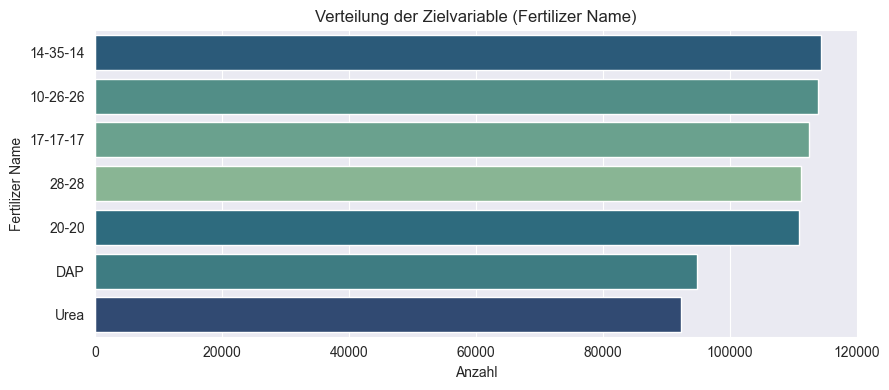

In [23]:
plt.figure(figsize=(9,4))
ax = sns.countplot(
    data=train,
    y='Fertilizer Name',
    hue='Fertilizer Name',  
    order=train['Fertilizer Name'].value_counts().index,
    palette="crest",
    legend=False 
)
plt.title('Verteilung der Zielvariable (Fertilizer Name)')
plt.xlabel('Anzahl')
plt.ylabel('Fertilizer Name')
plt.tight_layout()
plt.show()

## Numerische Merkmale

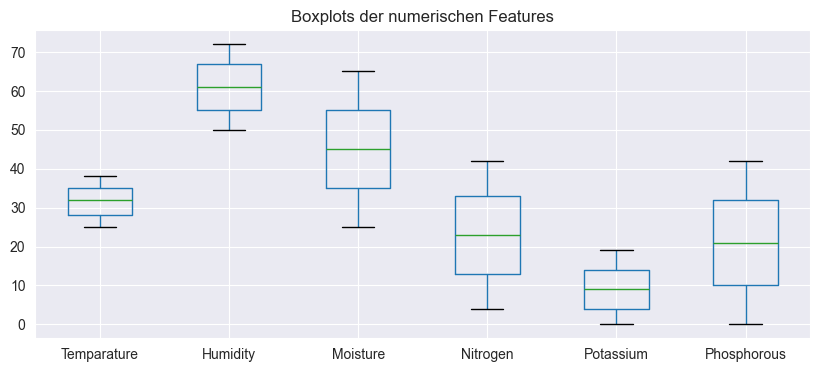

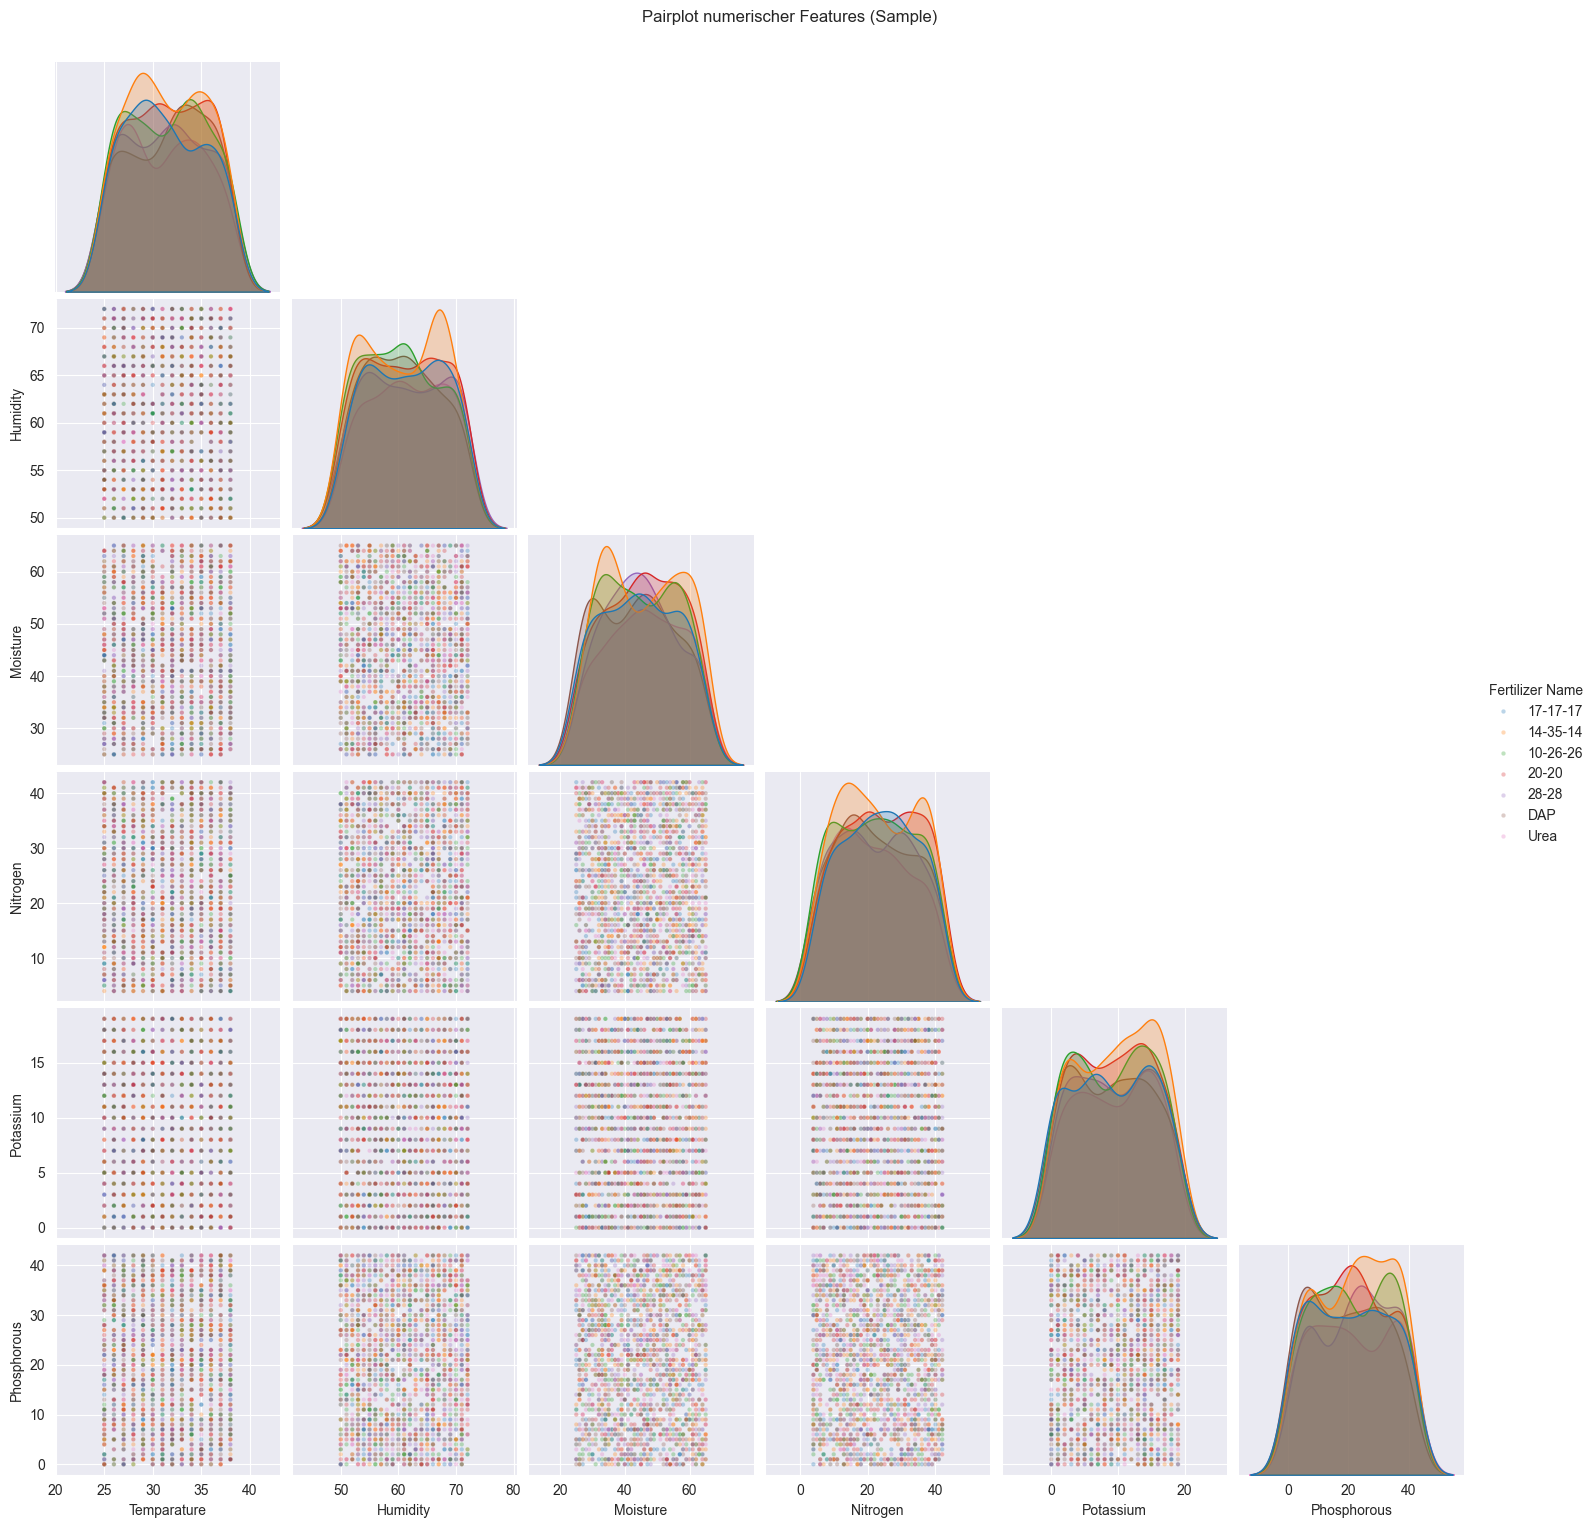

In [24]:
plt.figure(figsize=(10,4))
train[['Temparature','Humidity','Moisture','Nitrogen','Potassium','Phosphorous']].boxplot()
plt.title('Boxplots der numerischen Features')
plt.show()


sampled = train.sample(n=2000, random_state=42)

sns.pairplot(sampled, 
             vars=['Temparature','Humidity','Moisture','Nitrogen','Potassium','Phosphorous'], 
             hue='Fertilizer Name', corner=True, plot_kws={'alpha':0.3, 's':10})

plt.suptitle('Pairplot numerischer Features (Sample)', y=1.02)
plt.show()



## Kategorische Merkmale

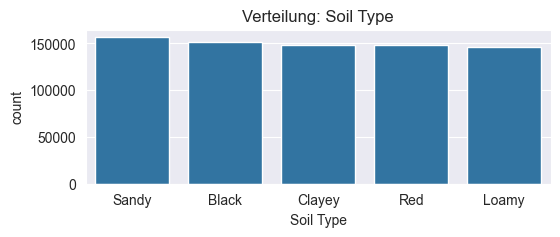

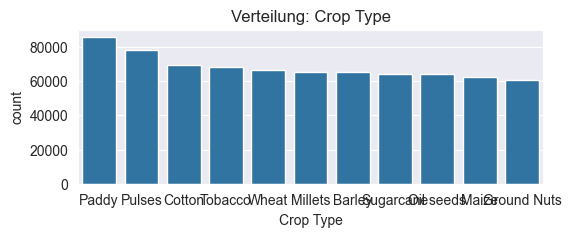

In [25]:
for col in ['Soil Type', 'Crop Type']:
    plt.figure(figsize=(6,2))
    sns.countplot(data=train, x=col, order=train[col].value_counts().index)
    plt.title(f'Verteilung: {col}')
    plt.show()


##  Korrelationsanalyse

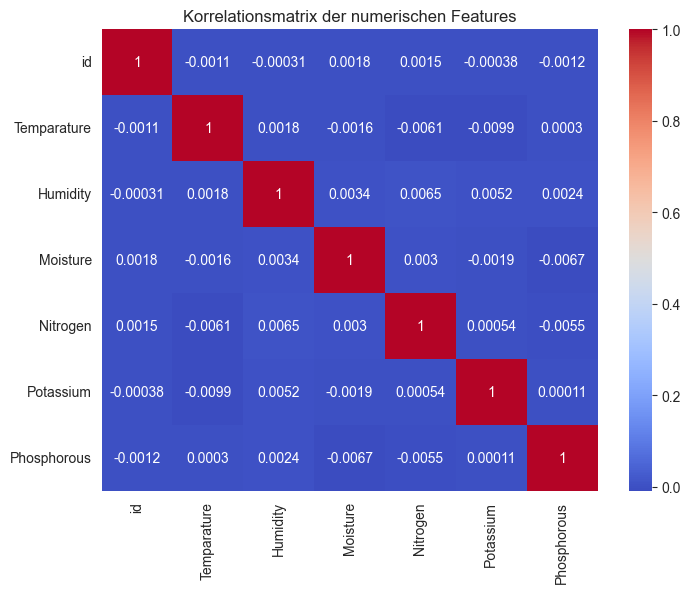

In [26]:
plt.figure(figsize=(8,6))
sns.heatmap(train.select_dtypes('number').corr(), annot=True, cmap='coolwarm')
plt.title('Korrelationsmatrix der numerischen Features')
plt.show()

 ## Datenvorverarbeitung

In [27]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Zielvariable
le = LabelEncoder()
train['Fertilizer_enc'] = le.fit_transform(train['Fertilizer Name'])

# Features und Spalten
categorical = ['Soil Type', 'Crop Type']
numerical = [col for col in train.columns if col not in categorical + ['id', 'Fertilizer Name', 'Fertilizer_enc']]

# Preprocessing-Pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
], remainder='passthrough')


## Modellierung RDM Forest

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

X = train.drop(columns=['id', 'Fertilizer Name', 'Fertilizer_enc'])
y = train['Fertilizer_enc']

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

rf_pipe = Pipeline([
    ('pre', preprocessor),
    ('model', RandomForestClassifier(random_state=42, n_jobs=-1))
])
rf_params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20]
}
rf_grid = GridSearchCV(rf_pipe, rf_params, cv=3, scoring='accuracy', verbose=1)
rf_grid.fit(X_train, y_train)

print("Random Forest beste Parameter:", rf_grid.best_params_)
print("Random Forest Accuracy (Validation):", rf_grid.score(X_val, y_val))


## Logistische Regression

preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical),
    (StandardScaler(), numerical)
)
logreg_pipe = Pipeline([
    ('pre', preprocessor),
    ('model', LogisticRegression(max_iter=5000, random_state=42))
])
logreg_params = {
    'model__C': [0.1, 1.0, 10.0]
}
logreg_grid = GridSearchCV(logreg_pipe, logreg_params, cv=3, scoring='accuracy', verbose=1)
logreg_grid.fit(X_train, y_train)

print("Logistische Regression beste Parameter:", logreg_grid.best_params_)
print("Logistische Regression Accuracy (Validation):", logreg_grid.score(X_val, y_val))


## Gradient Boosting

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from xgboost import XGBClassifier

# 1. Feature Engineering: NPK, Verhältnisse, Binning, Interaktion
def add_features(df):
    df = df.copy()
    df['NPK_total'] = df['Nitrogen'] + df['Phosphorous'] + df['Potassium']
    df['N_to_P'] = df['Nitrogen'] / (df['Phosphorous'] + 1e-8)
    df['K_to_N'] = df['Potassium'] / (df['Nitrogen'] + 1e-8)
    df['Temp_bin'] = pd.cut(df['Temparature'], bins=3, labels=False)
    df['Moisture_bin'] = pd.qcut(df['Moisture'], 4, labels=False, duplicates='drop')
    df['Soil_Crop'] = df['Soil Type'].astype(str) + "_" + df['Crop Type'].astype(str)

    return df

train = add_features(train)
test = add_features(test)

categorical = [
    'Soil Type', 'Crop Type', 'Temp_bin', 'Moisture_bin', 'Soil_Crop'
]
numerical = [
    'Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous',
    'NPK_total', 'N_to_P', 'K_to_N'
]

# 2. Label Encoding für ALLE Kategorischen Features (train & test zusammen fitten!)
for col in categorical:
    le = LabelEncoder()
    vals = pd.concat([train[col], test[col]], axis=0).astype(str)
    le.fit(vals)
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

target = 'Fertilizer_enc'
X = train[categorical + numerical]
y = train[target]

# 3. Validation-Split (für Score, aber am Ende GANZ fitten!)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# ======= Hyperparameter-Optimierung Schritt-für-Schritt =======

# Step 1: max_depth, n_estimators
params1 = {
    'max_depth': [4, 5, 6, 7],
    'n_estimators': [120, 150, 200, 250]
}
xgb1 = XGBClassifier(tree_method='hist', eval_metric='mlogloss', random_state=42)
search1 = RandomizedSearchCV(
    xgb1, params1, n_iter=6, cv=cv, scoring='accuracy',
    verbose=2, n_jobs=-1, random_state=38
)
search1.fit(X_train, y_train)
print("Step 1 - Beste Params:", search1.best_params_)
print("Step 1 - Best Score:", search1.best_score_)

best_max_depth = search1.best_params_['max_depth']
best_n_estimators = search1.best_params_['n_estimators']

# Step 2: learning_rate, subsample
params2 = {
    'max_depth': [best_max_depth],
    'n_estimators': [best_n_estimators],
    'learning_rate': [0.03, 0.05, 0.07, 0.1, 0.13],
    'subsample': [0.7, 0.8, 1.0]
}
xgb2 = XGBClassifier(tree_method='hist', eval_metric='mlogloss', random_state=42)
search2 = RandomizedSearchCV(
    xgb2, params2, n_iter=6, cv=cv, scoring='accuracy',
    verbose=2, n_jobs=-1, random_state=38
)
search2.fit(X_train, y_train)
print("Step 2 - Beste Params:", search2.best_params_)
print("Step 2 - Best Score:", search2.best_score_)

best_learning_rate = search2.best_params_['learning_rate']
best_subsample = search2.best_params_['subsample']

# Step 3: colsample_bytree, min_child_weight (letzter Feinschliff)
params3 = {
    'max_depth': [best_max_depth],
    'n_estimators': [best_n_estimators],
    'learning_rate': [best_learning_rate],
    'subsample': [best_subsample],
    'colsample_bytree': [0.7, 0.8, 1.0]
    # min_child_weight kommt im Blending!
}
xgb3 = XGBClassifier(tree_method='hist', eval_metric='mlogloss', random_state=21)
search3 = RandomizedSearchCV(
    xgb3, params3, n_iter=3, cv=cv, scoring='accuracy',
    verbose=2, n_jobs=-1, random_state=34
)
search3.fit(X_train, y_train)
print("Step 3 - Beste Params:", search3.best_params_)
print("Step 3 - Best Score:", search3.best_score_)

final_params = search3.best_params_

# ======== BLENDING: Drei Modelle, verschiedene Seeds & min_child_weight ========
proba_sum = 0
n_models = 3
blend_settings = [(26, 1), (555, 2), (777, 3)]  # seed, min_child_weight

for seed, min_child_weight in blend_settings:
    blend_params = final_params.copy()
    blend_params['min_child_weight'] = min_child_weight  # Hier überschreiben
    xgb_model = XGBClassifier(
        tree_method='hist',
        eval_metric='mlogloss',
        random_state=seed,
        **blend_params
    )
    xgb_model.fit(X, y)
    proba_sum += xgb_model.predict_proba(test[categorical + numerical])

blended_proba = proba_sum / n_models

# Top-3 Submission
top3_indices = np.argsort(blended_proba, axis=1)[:, -3:][:, ::-1]
label_map = train[['Fertilizer_enc', 'Fertilizer Name']].drop_duplicates().sort_values('Fertilizer_enc')
names = label_map['Fertilizer Name'].values
top3_names = [" ".join([names[i] for i in row]) for row in top3_indices]

submission = test[['id']].copy()
submission['Fertilizer Name'] = top3_names
submission.to_csv("submission_blend.csv", index=False)
print(submission.head())


Fitting 3 folds for each of 6 candidates, totalling 18 fits


## ALTE VERSION HATTE BISHER BESTES ERGEBNIS ABER SCHEIße RECHENINTENSIV

def add_features(df):
    df = df.copy()
    df['N_to_P'] = df['Nitrogen'] / (df['Phosphorous'] + 1e-8)
    df['K_to_N'] = df['Potassium'] / (df['Nitrogen'] + 1e-8)
    df['NPK_total'] = df['Nitrogen'] + df['Phosphorous'] + df['Potassium']
    df['Temp_bin'] = pd.cut(df['Temparature'], bins=3, labels=False)
    return df

train = add_features(train)
test = add_features(test)

train['Moisture_bin'] = pd.qcut(train['Moisture'], 5, labels=False)
test['Moisture_bin'] = pd.qcut(test['Moisture'], 5, labels=False)

train['Soil_Crop'] = train['Soil Type'] + "_" + train['Crop Type']
test['Soil_Crop'] = test['Soil Type'] + "_" + test['Crop Type']

train['Crop_TempBin'] = train['Crop Type'] + "_T" + train['Temp_bin'].astype(str)
test['Crop_TempBin'] = test['Crop Type'] + "_T" + test['Temp_bin'].astype(str)

train['Soil_TempBin'] = train['Soil Type'] + "_T" + train['Temp_bin'].astype(str)
test['Soil_TempBin'] = test['Soil Type'] + "_T" + test['Temp_bin'].astype(str)

train['Soil_MoistureBin'] = train['Soil Type'] + "_M" + train['Moisture_bin'].astype(str)
test['Soil_MoistureBin'] = test['Soil Type'] + "_M" + test['Moisture_bin'].astype(str)

train['Humidity_by_Moisture'] = train['Humidity'] / (train['Moisture'] + 1e-8)
test['Humidity_by_Moisture'] = test['Humidity'] / (test['Moisture'] + 1e-8)

categorical = [
    'Soil Type',
    'Crop Type',
    'Temp_bin',
    'Soil_Crop', 
    'Crop_TempBin', 
    'Soil_TempBin', 
    #'Soil_MoistureBin',
    #'Moisture_bin'
]
numerical = [
    'Temparature',
    #'Humidity',
    'Moisture',
    'Nitrogen',
    'Potassium', 
    'Phosphorous',
    'N_to_P', 
    'K_to_N', 
    'NPK_total', 
    'Humidity_by_Moisture'
]


X = train[categorical + numerical]
y = train['Fertilizer_enc']
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', StandardScaler(), numerical)
])

xgb = XGBClassifier(
    tree_method="hist",  # oder 'gpu_hist' für GPU
    eval_metric='mlogloss',
    random_state=42
)

xgb_pipe = Pipeline([
    ('pre', preprocessor),
    ('model', xgb)
])

X_sub, _, y_sub, _ = train_test_split(X_train, y_train, train_size=0.2, stratify=y_train, random_state=42)
params1 = {
    "model__n_estimators": [100, 200, 400, 800],
    "model__max_depth": [4, 6, 8, 10]
}
search1 = RandomizedSearchCV(
    xgb_pipe, params1, n_iter=8, cv=2, scoring='accuracy', n_jobs=-1, random_state=42, verbose=2
)
search1.fit(X_sub, y_sub)
best_n_estimators = search1.best_params_["model__n_estimators"]
best_max_depth = search1.best_params_["model__max_depth"]

params2 = {
    "model__n_estimators": [best_n_estimators],
    "model__max_depth": [best_max_depth],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "model__subsample": [0.6, 0.8, 1.0]
}
search2 = RandomizedSearchCV(
    xgb_pipe, params2, n_iter=6, cv=2, scoring='accuracy', n_jobs=-1, random_state=42, verbose=2
)
search2.fit(X_sub, y_sub)
best_learning_rate = search2.best_params_["model__learning_rate"]
best_subsample = search2.best_params_["model__subsample"]

params3 = {
    "model__n_estimators": [best_n_estimators],
    "model__max_depth": [best_max_depth],
    "model__learning_rate": [best_learning_rate],
    "model__subsample": [best_subsample],
    "model__colsample_bytree": [0.6, 0.8, 1.0],
    "model__min_child_weight": [1, 3, 5]
}
search3 = RandomizedSearchCV(
    xgb_pipe, params3, n_iter=6, cv=2, scoring='accuracy', n_jobs=-1, random_state=42, verbose=2
)
search3.fit(X_sub, y_sub)
best_colsample = search3.best_params_["model__colsample_bytree"]
best_min_child_weight = search3.best_params_["model__min_child_weight"]



params4 = {
    "model__n_estimators": [best_n_estimators],
    "model__max_depth": [best_max_depth],
    "model__learning_rate": [best_learning_rate],
    "model__subsample": [best_subsample],
    "model__colsample_bytree": [best_colsample],
    "model__min_child_weight": [best_min_child_weight],
    "model__reg_alpha": [0, 0.1, 0.5, 1.0],
    "model__reg_lambda": [0.5, 1.0, 2.0],
    "model__gamma": [0, 0.1, 0.5, 1.0]
}
search4 = RandomizedSearchCV(
    xgb_pipe, params4, n_iter=10, cv=2, scoring='accuracy', n_jobs=-1, random_state=42, verbose=2
)
search4.fit(X_sub, y_sub)
best_reg_alpha = search4.best_params_["model__reg_alpha"]
best_reg_lambda = search4.best_params_["model__reg_lambda"]
best_gamma = search4.best_params_["model__gamma"]


final_params = {
    "model__n_estimators": [best_n_estimators],
    "model__max_depth": [best_max_depth],
    "model__learning_rate": [best_learning_rate],
    "model__subsample": [best_subsample],
    "model__colsample_bytree": [best_colsample],
    "model__min_child_weight": [best_min_child_weight],

}
search_final = RandomizedSearchCV(
    xgb_pipe, final_params, n_iter=1, cv=5, scoring='accuracy', n_jobs=-1, random_state=42, verbose=2
)
search_final.fit(X_train, y_train)
print("FINAL beste Parameter:", search_final.best_params_)
print("FINAL bester Score:", search_final.best_score_)
print("Accuracy auf Validation:", search_final.score(X_val, y_val))


# DataFrame mit allen getesteten Kombinationen und ihrem Score
results = pd.DataFrame(search3.cv_results_)  # z. B. letzter RandomizedSearchCV

# Relevante Spalten anzeigen
cols = [
    'mean_test_score',
    'param_model__n_estimators', 'param_model__max_depth',
    'param_model__learning_rate', 'param_model__subsample',
    'param_model__colsample_bytree', 'param_model__min_child_weight'
]
display(results[cols].sort_values('mean_test_score', ascending=False))

# Pivot für Heatmap: max_depth vs. learning_rate
pivot = results.pivot_table(
    index='param_model__max_depth',
    columns='param_model__learning_rate',
    values='mean_test_score'
)
plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="crest")
plt.title("Mean CV-Score: max_depth vs. learning_rate")
plt.show()

# Scatterplot: learning_rate vs. mean_test_score, eingefärbt nach max_depth
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=results,
    x='param_model__learning_rate',
    y='mean_test_score',
    hue='param_model__max_depth',
    palette='crest',
    s=100
)
plt.title("Test-Score nach learning_rate und max_depth")
plt.show()
plt.show()

import numpy as np
# Features für Test-Set wie im Training
test_features = test[categorical + numerical]

# Vorhersage-Wahrscheinlichkeiten
best_model = search_final.best_estimator_
probas = best_model.predict_proba(test_features)

# Top-3 für jede Zeile
top3_indices = np.argsort(probas, axis=1)[:, -3:][:, ::-1]

# Encodings wieder zurück in Namen
top3_names = [" ".join(le.inverse_transform(row)) for row in top3_indices]

submission = test[['id']].copy()
submission['Fertilizer Name'] = top3_names
submission.to_csv("submission.csv", index=False)
display(submission.head())


submission = pd.DataFrame({
    'id': test['id'],
    'Fertilizer Name': top3_names
})

submission.to_csv('submission.csv', index=False)

booster = search_final.best_estimator_.named_steps['model']
importances = booster.feature_importances_
feature_names = search_final.best_estimator_.named_steps['pre'].get_feature_names_out()
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

feat_imp.head(20).plot(kind='barh', figsize=(8,6))
plt.title("Feature Importance (XGBoost)")
plt.show()


# Feature Importance nach dem Modelltraining:
import matplotlib.pyplot as plt
feat_imp = search_final.best_estimator_.named_steps['model'].feature_importances_
feat_names = search_final.best_estimator_.named_steps['pre'].get_feature_names_out()
pd.Series(feat_imp, index=feat_names).sort_values(ascending=False).head(20).plot.bar(figsize=(12,3))
plt.title("Top 20 Feature Importances")
plt.show()
